# Reanalysis of Sun et al., Nature 2024

https://www.nature.com/articles/s41586-023-07011-6

Eran Mukamel (emukamel@ucsd.edu)


In [9]:
import pandas as pd,seaborn as sns,numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from multiprocessing import Pool
sc.settings.verbosity=3
sc.settings.set_figure_params(dpi=100)

from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
tqdm.pandas()
from adjustText import adjust_text

# Load data from GEO files

Load data from GEO: https://www.ncbi.nlm.nih.gov/gds/?term=GSE246147[Accession]


In [6]:
%%time
adata=sc.read_mtx('GSE246147/GSE246147_matrix.mtx.gz')
adata=adata.T


KeyboardInterrupt



In [7]:
adata.var=(pd.read_csv('GSE246147/GSE246147_features.tsv.gz',sep='\t',usecols=[1],names=['Gene']))
adata.obs=pd.read_csv('GSE246147/GSE246147_barcodes.tsv.gz',sep='\t',names=['barcode'],usecols=[1],index_col=0)
celltypes=pd.read_csv('GSE246147/GSE246147_cell_type_data.csv.gz',index_col=0)
adata.obs=adata.obs.join(celltypes,how='left')
adata.var=adata.var.set_index('Gene')

In [8]:
# Load metadata provided by Wenfei sun
# The CSV files are at: 
# https://www.dropbox.com/scl/fi/rcj6chqy58l62vsl750r3/BLA-neuron-and-inhibitory-neuron-cell-type.csv?rlkey=8rce3cqfbt897bh1flfzxhyrs&dl=0
# https://www.dropbox.com/scl/fi/cobijwno0o5l5n2ouo7s1/Engram-annotation.csv?rlkey=bkxanahuetbecq4lnaempx4ho&dl=0
annot_engram=pd.read_csv('Engram annotation.csv',usecols=[1,5])

annot=pd.read_csv('BLA neuron and inhibitory neuron cell type.csv',usecols=[0,1],header=1)
annot_inh=pd.read_csv('BLA neuron and inhibitory neuron cell type.csv',usecols=[4,5],header=1).dropna()
annot_inh=annot_inh.rename(columns={'Cell.1':'Cell'})
annot=annot.merge(annot_inh,on='Cell',how='outer').set_index('Cell')
annot=annot.fillna('-')

for c in annot_engram:
    annot[c]='-'
    annot.loc[annot_engram[c].dropna(),c]=c

adata.obs['cell_id2']=adata.obs.index.str.replace(r'_S[0-9]+$','',regex=True)
adata.obs=adata.obs.reset_index().merge(annot.reset_index(),how='left',left_on='cell_id2',right_on='Cell',validate='1:1')
adata.obs=adata.obs.set_index('barcode')
adata.obs=adata.obs.fillna('-')

# adata.uns['X_umap']=
umap=pd.read_csv('GSE246147/GSE246147_umap_data.csv.gz',
                               index_col=0)
umap.index=umap.index.str.upper()
adata.obsm['X_umap']=umap.values

adata.obs['condition']=adata.obs['cell_id2'].str[:2]
adata.obs['animal']=[s.split('_')[0] for s in adata.obs.index]


KeyboardInterrupt



In [ ]:
annot_engram=pd.read_csv('Engram annotation.csv',usecols=[1,5])

annot=pd.read_csv('BLA neuron and inhibitory neuron cell type.csv',usecols=[0,1],header=1)
annot_inh=pd.read_csv('BLA neuron and inhibitory neuron cell type.csv',usecols=[4,5],header=1).dropna()
annot_inh=annot_inh.rename(columns={'Cell.1':'Cell'})
annot=annot.merge(annot_inh,on='Cell',how='outer').set_index('Cell')
annot=annot.fillna('-')

for c in annot_engram:
    annot[c]='-'
    annot.loc[annot_engram[c].dropna(),c]=c

annot_engram

In [ ]:
# Store the data in h5ad so it can be quickly loaded
adata.write_h5ad('GSE246147_annotated.h5ad')

# Load the stored h5ad data

In [10]:
adata=sc.read_h5ad('GSE246147_annotated.h5ad')
adata.var=adata.var.set_index('Gene')

/home/emukamel/mambaforge/envs/analysis/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
adata.obs['condition']=adata.obs['cell_id2'].str[:2]
adata.obs['animal']=[s.split('_')[0] for s in adata.obs.index]

# Replicate analysis from Fig. 2e

In [12]:
# Subset to the Int.Gpr88 cells. These are from the initial clustering of all cells (not just inhibitory cells)
adata_2e=adata[adata.obs['BLA.Int.Gpr88 engram neurons']=='BLA.Int.Gpr88 engram neurons']

In [82]:
adata_2e

View of AnnData object with n_obs × n_vars = 70 × 44272
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'cell_id2', 'Cell', 'Cell_Type', 'Cell_Type.1', 'BLA.Int.Gpr88 engram neurons', 'BlaIn.Gpr88 engram neurons', 'condition', 'animal'
    var: 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_umap'

(0.0, 30.0)

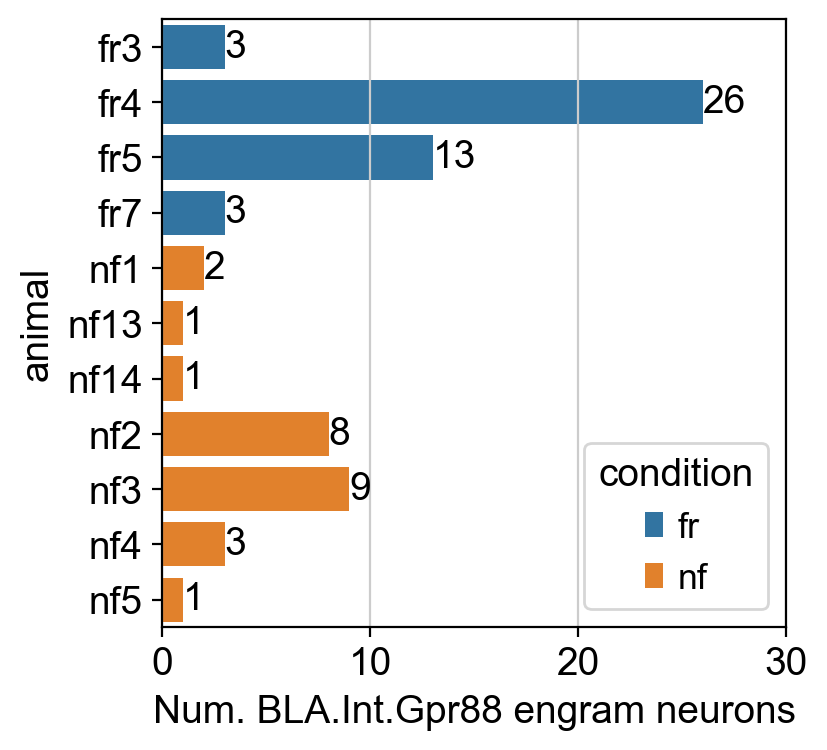

In [76]:
# Bar plot of number of neurons per animal
ax=sns.countplot(adata_2e.obs.sort_values('animal'),y='animal',hue='condition',dodge=False)
ax.set_xlabel('Num. BLA.Int.Gpr88 engram neurons')
for c in ax.containers:
    ncells=[int(p.get_width()) for p in c.patches]
    ax.bar_label(container=c, labels=ncells)
plt.xlim([0,30])

In [77]:
ax.figure.savefig('Plots/SunQuake_NumCells_barplot.pdf')

In [14]:
adata_show=adata_2e

# These are the DE genes labeled in Fig. 2E:
de_genes=['Tac1','Cartpt','Ramp1','Tln2','Lamp5','Chrm1','Mtf2','Mcf2l','Commd3','Hist3h2ba',
          'Hnrnph1','Opcml','Plppr4','Snw1','Gria2',
          'Saraf','Tuba4a','Tubb4b','Magoh','Penk','Cend1','Dnmt1','Tmem59l','Sult2b1','Cndp2',
          'Pea15a','Aptx','Apoe',
          'Fbxo44','Crabp1','Scn2b','Gnl2'
         ]

In [15]:
# Calculate normalized pseudobulk for each animal
df=adata_show.to_df()

In [16]:
libsize=df.sum(axis=1)
df=1e6*df.div(libsize,axis=0)

In [17]:
df[de_genes].max(axis=0).min()

630.662776529789

In [18]:
# Remove non-expressed genes. Trying to replicate the number of genes shown in Fig. 2E
min_expression = 630.66
min_expression = 600
df=df.loc[:,df.max(axis=0)>min_expression]
print(f'Keeping {df.shape[1]}/{adata_show.shape[1]} genes with >{min_expression} CPM')

Keeping 3574/44272 genes with >600 CPM


In [19]:
# Log transform the counts
df=np.log2(df+1)

df=df.join(adata.obs[['cell_type','condition','animal']])
df=df.reset_index()
df=df.groupby(['cell_type','condition','animal','barcode']).mean()
df.columns.names=['Gene']

df=df.reset_index().set_index(['animal','condition','cell_type',
                               'barcode'
                              ])
df = df.dropna()
df=df.stack().rename('Expression').reset_index()

df['condition']=df['condition'].astype(str)

/scratch/ipykernel_170061/3942708245.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df=df.groupby(['cell_type','condition','animal','barcode']).mean()


In [20]:
# Merge NF animals
animals = df['animal'].unique()
df['animal_original']=df['animal']

animal2pool = {a:a for a in animals}
animal2pool.update({'nf5':'nf5_14_13','nf14':'nf5_14_13','nf13':'nf5_14_13',
                   'nf1':'nf1_4','nf4':'nf1_4'})
df['animal']=df['animal_original'].map(animal2pool)
df[df['Gene']=='Vxn']['animal'].value_counts()

animal
fr4          26
fr5          13
nf3           9
nf2           8
nf1_4         5
fr3           3
fr7           3
nf5_14_13     3
Name: count, dtype: int64

In [21]:
# Group by animal - pseudobulk
df_byanimal=df.groupby(['animal','condition','Gene'])['Expression'].mean().dropna().reset_index()

In [22]:
animals = df['animal'].unique()
animals_shuf = np.random.permutation(animals)
animals_shuf = {a1:a2+'_shuff' for a1,a2 in zip(animals, animals_shuf)}
animals_shuf
df['animal_shuff']=df['animal'].map(animals_shuf)
df['condition_shuff']=df['animal_shuff'].str[:2]

In [23]:
from scipy.stats import mannwhitneyu
def _mannwhitneyu(df, doshuffle=False):
    condition = df['condition_shuff'] if doshuffle else df['condition']

    # try:
    p=mannwhitneyu(df.loc[condition=='fr','Expression'],
         df.loc[condition=='nf','Expression'],
                   alternative='two-sided',
        ).pvalue
    # except:
    #     gene=df.iloc[0].index
    #     print(f'Error for {gene}')
    #     p=np.nan
    return p

In [24]:
pvals=df.groupby(['Gene'])[['Expression','condition']].progress_apply(_mannwhitneyu)
pvals_byanimal=df_byanimal.groupby(['Gene'])[['Expression','condition']].progress_apply(_mannwhitneyu)

100%|██████████| 3574/3574 [00:07<00:00, 467.31it/s]


In [25]:
logfc=df.groupby(['condition','Gene'])['Expression'].mean()
logfc=logfc['fr']-logfc['nf']
df_stats_bycell=pd.concat({'P-value':pvals,'Log2FC':logfc},axis=1,names=['stat'])
_,df_stats_bycell['FDR']=fdrcorrection(df_stats_bycell['P-value'])

logfc_byanimal=df_byanimal.groupby(['condition','Gene'])['Expression'].mean()
logfc_byanimal=logfc_byanimal['fr']-logfc_byanimal['nf']
df_stats_byanimal=pd.concat({'P-value':pvals_byanimal,'Log2FC':logfc_byanimal},axis=1,names=['stat'])
_,df_stats_byanimal['FDR']=fdrcorrection(df_stats_byanimal['P-value'])

In [26]:
rng=np.random.default_rng(seed=1)
animals_shuff = rng.permutation(animals)
animals_shuff = {a1:a2+'_shuff' for a1,a2 in zip(animals, animals_shuff)}
df['animal_shuff']=df['animal'].map(animals_shuff)
df['condition_shuff']=df['animal_shuff'].str[:2]
pvals_shuff=df.groupby(['Gene'])[['Expression','condition_shuff']].progress_apply(_mannwhitneyu,doshuffle=True)
logfc_shuff=df.groupby(['condition_shuff','Gene'])['Expression'].mean()
logfc_shuff=logfc_shuff['fr']-logfc_shuff['nf']

df_stats_shuff=pd.concat({'P-value':pvals_shuff,'Log2FC':logfc_shuff},axis=1,names=['stat'])
_,df_stats_shuff['FDR']=fdrcorrection(df_stats_shuff['P-value'])

100%|██████████| 3574/3574 [00:07<00:00, 466.86it/s]


In [27]:
df_stats=pd.concat({'By cell':df_stats_bycell,'By animal':df_stats_byanimal,'By cell (shuffled)':df_stats_shuff},axis=1,names=['stats_type'])
df_stats=df_stats.stack('stats_type',future_stack=True)

In [28]:
df_stats['DE'] = (df_stats.index.get_level_values('Gene').isin(de_genes))

In [29]:
# Save the statistics to hdf5 file
# df_stats.to_hdf('SunQuake_Fig2e_stats.hdf',key='stats')

In [30]:
# Impose a threshold on log-fold change
df_stats['P (logfc>1.75)'] = df_stats['P-value'] + (df_stats['Log2FC'].abs()<np.log2(1.75))
df_stats['P (logfc>1.75)'] = df_stats['P (logfc>1.75)'].clip(0,1)

In [31]:
# Transform to long-form
df_stats2=df_stats[['FDR','P-value','P (logfc>1.75)']].stack().rename('Significance').reset_index()
df_stats2=df_stats2.merge(df_stats.reset_index()[['Gene','stats_type','Log2FC']],on=['Gene','stats_type'])
df_stats2['DE'] = (df_stats2['Gene'].isin(de_genes))
df_stats2=df_stats2.sort_values(['DE'])

In [32]:
df_stats2['-Log10(Significance)']=-np.log10(df_stats2['Significance'])
df_stats['-Log10(P-value)']=-np.log10(df_stats['P-value'])
df_stats['-Log10(FDR)']=-np.log10(df_stats['FDR'])

In [33]:
ngenes_tested=df['Gene'].nunique()

P-value By cell
P-value By animal
FDR By cell
FDR By animal


Text(0.5, 1.05, 'Tested 3574 genes')

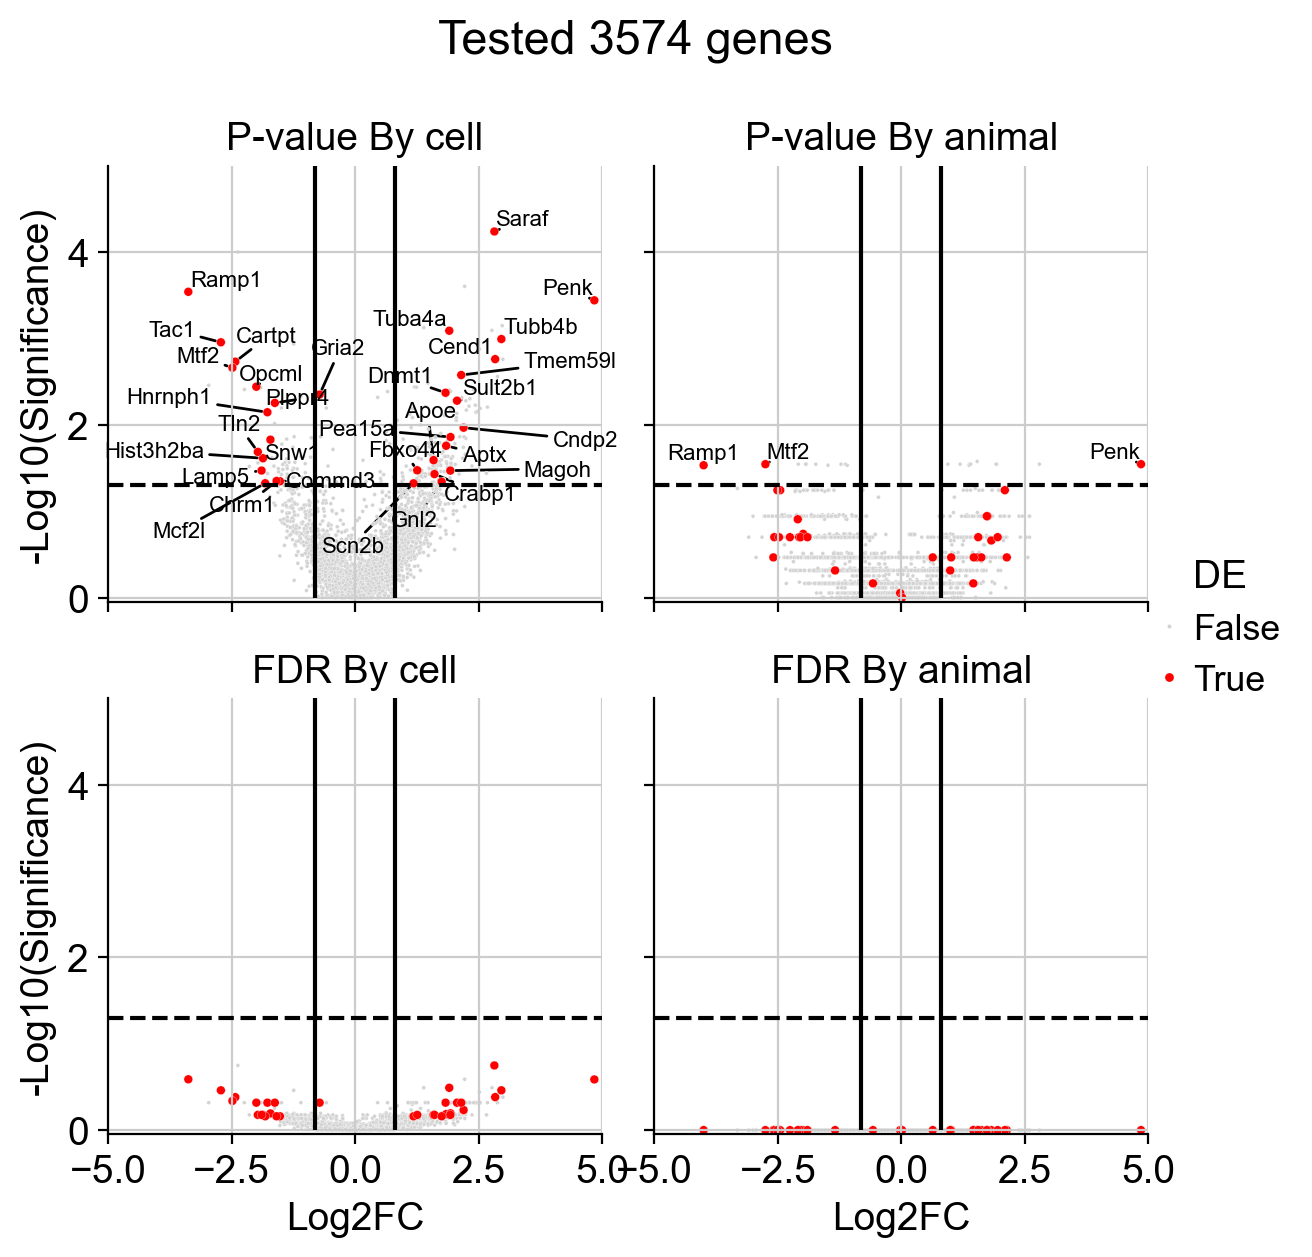

In [80]:
g=sns.relplot(df_stats2,
               kind='scatter',
               x='Log2FC',y='-Log10(Significance)',
               hue='DE',palette={False:'lightgray',True:'r'},
               col='stats_type',
              col_order=['By cell',
                         # 'By cell (shuffled)',
                         'By animal'],
              row='stat',
              row_order=['P-value','FDR'],
                   size='DE',
                   sizes={True:10,False:2},
              height=3,
              facet_kws=dict(sharex=True,sharey=True),
                  )
g.set_titles('{row_name} {col_name}')
for k in g.axes_dict:
    ax=g.axes_dict[k]
    ax.grid(True)
    ax.hlines(-np.log10(0.05), -5,5,'k',linestyle='--')
    ax.vlines([-.8074,.8074],0,5,'k')

# for k in ['By cell','By cell b(shuffled)','By animal']:
for stat,k in g.axes_dict:
    print(stat,k)
    ax=g.axes_dict[(stat,k)]
    # ax=g.axes_dict[('P-value',k)]
    texts=[]
    for gene in de_genes:
        if df_stats.loc[(gene,k),stat]<.05:
            t=ax.text(df_stats.loc[(gene,k),'Log2FC'],df_stats.loc[(gene,k),f'-Log10({stat})'],gene,fontsize=8)
            texts.append(t)
            # break

            
    if len(texts)>0:
        adjust_text(texts,ax=ax,arrowprops=dict(arrowstyle='-', color='k',),
                    # expand_objects=(1.1,1.3),
                    zorder=-1 )

ax.set_xlim([-5,5])
ax.set_ylim([-.05,5])
g.fig.suptitle(f'Tested {ngenes_tested} genes',y=1.05)

In [79]:
g.fig.savefig('Plots/SunQuake_VolcanoPlots.pdf')

In [36]:
df_stats2['Sig']=(df_stats2['Significance']<0.05)
df_stats2.groupby(['stats_type','stat'])['Sig'].sum().unstack()

stat,FDR,P (logfc>1.75),P-value
stats_type,,,
By animal,0,21,21
By cell,0,230,253
By cell (shuffled),1,453,471


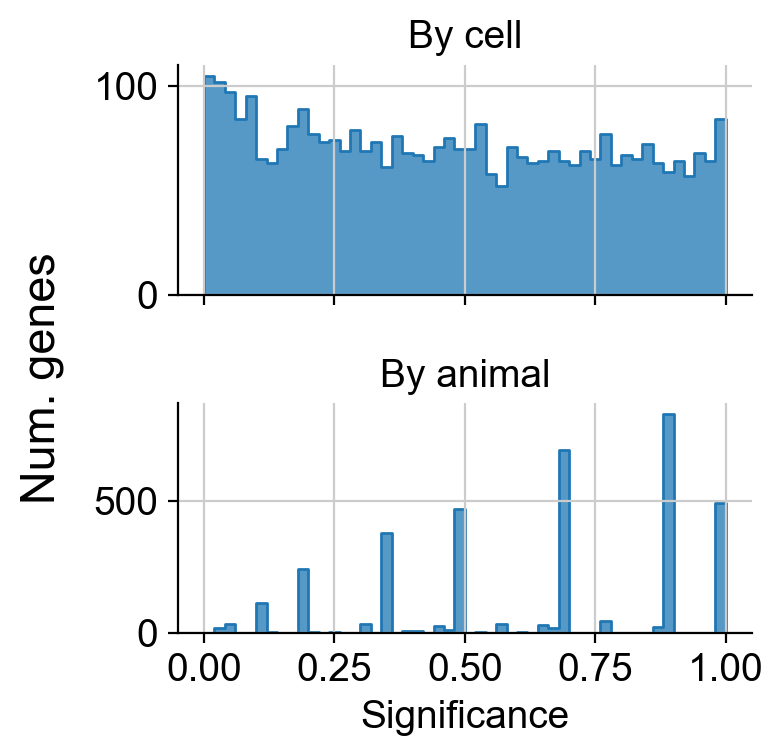

In [37]:
g=sns.displot(df_stats2,kind='hist',x='Significance',
              col='stat',col_order=['P-value'],
            row='stats_type',row_order=['By cell','By animal'],
            height=2,
              aspect=2,
            facet_kws=dict(sharey=False),element='step',bins=50,
              common_norm=False,
           )
g.set_titles('{row_name}')
# g.set_xlabels('P-value')
g.set(xticks=[0,.25,.5,.75,1])
g.set_ylabels('')
g.fig.supylabel('Num. genes')
# g.axes[0,0].set_ylim([0,1000])

g.fig.savefig('Plots/SunQuake_Pval_histogram.pdf')

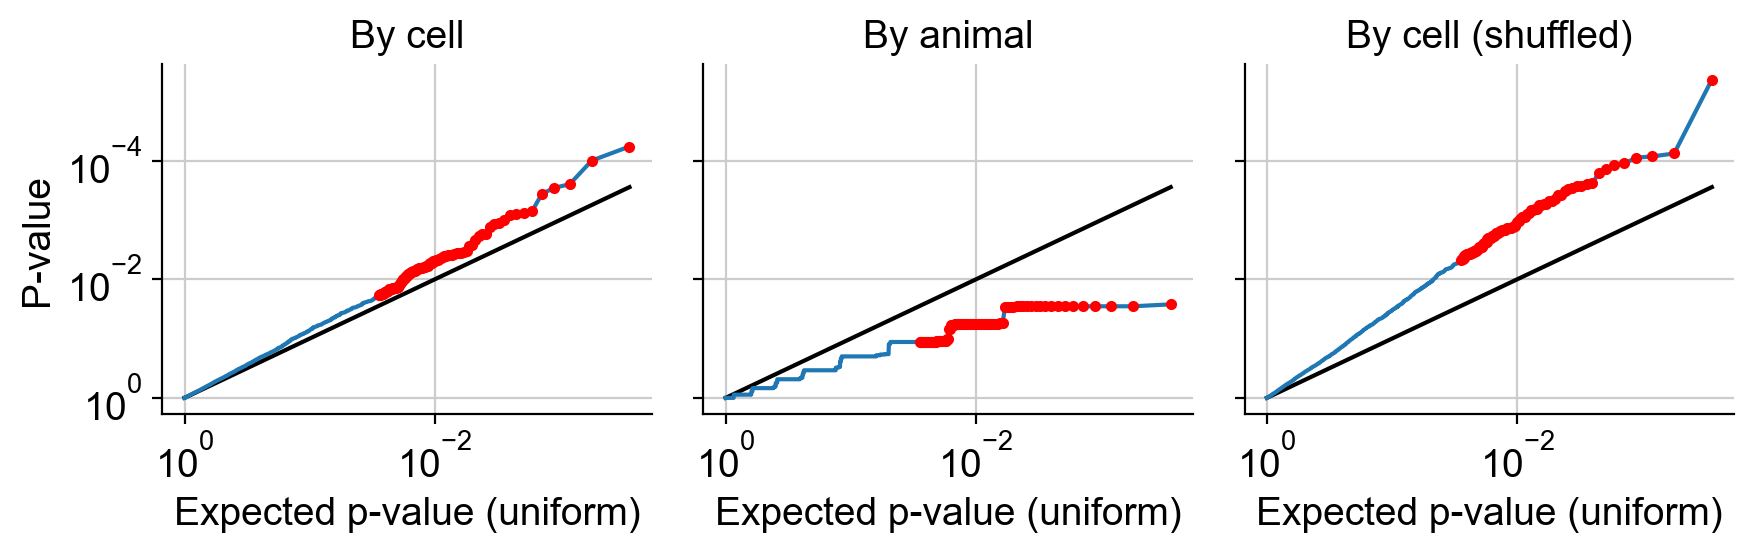

In [38]:
# QQ plots
import matplotlib.pyplot as plt
def my_qqplot(pvals,color='k'):
    psort=np.sort(pvals.values)
    n=len(pvals)
    pctrl=(np.arange(n)+1)/n
    plt.plot([1/n,1],[1/n,1],'k')
    ax=sns.lineplot(x=pctrl, y=psort)
    ax.plot(pctrl[:100],psort[:100],'o',markersize=3,color='r')
    ax.set_yscale('log')
    ax.set_xscale('log')

    if not ax.get_xaxis().get_inverted():
        ax.invert_xaxis()
    if not ax.get_yaxis().get_inverted():
        ax.invert_yaxis()

    plt.ylabel('P-value')
    return

g=sns.FacetGrid(df_stats2,row='stat',
                col='stats_type',col_order=['By cell','By animal','By cell (shuffled)'],
            height=3,row_order=['P-value'])
g.map(my_qqplot,'Significance')
g.set_titles('{col_name}')
g.set_xlabels('Expected p-value (uniform)')

# Shuffle cells

In [42]:
# Shuffle cells
def shuffcells_stats(seed,df=df):
    if seed is not None:
        rng=np.random.default_rng(seed)        
        barcodes=df['barcode'].unique()
        barcodes_shuff = rng.permutation(barcodes)
    else:
        barcodes=df['barcode'].unique()
        barcodes_shuff=barcodes
    barcodes_shuff={a:b for a,b in zip(barcodes, barcodes_shuff)}
    df['barcode_shuff']=df['barcode'].map(barcodes_shuff)
    df['animal_shuff']=df['barcode_shuff'].str.replace('_.*_S[0-9]+$','',regex=True)
    df['condition_shuff']=df['animal_shuff'].str[:2]
    
    pvals_shuff=df.groupby(['Gene'])[['Expression','condition_shuff']].apply(_mannwhitneyu,doshuffle=True)
    logfc_shuff=df.groupby(['condition_shuff','Gene'])['Expression'].mean()
    logfc_shuff=logfc_shuff['fr']-logfc_shuff['nf']
    
    _,fdr=fdrcorrection(pvals_shuff)
    ngenes={'seed':animals_shuff,
            'P<0.05 by cell':(pvals_shuff<0.05).sum(),
     'P<0.05 and FC>1.75 by cell':((pvals_shuff<0.05)&(logfc_shuff.abs()>np.log2(1.75))).sum(),
           'FDR<0.05 by cell':(fdr<0.05).sum()}

    df_byanimal=df.groupby(['animal_shuff','condition_shuff','Gene'])['Expression'].mean().dropna().reset_index()
    
    pvals_byanimal=df_byanimal.groupby(['Gene'])[['Expression','condition_shuff']].apply(_mannwhitneyu,doshuffle=True)
    _,fdr_byanimal=fdrcorrection(pvals_byanimal)
    
    logfc_shuff=df_byanimal.groupby(['condition_shuff','Gene'])['Expression'].mean()
    logfc_shuff=logfc_shuff['fr']-logfc_shuff['nf']

    ngenes.update({'P<0.05 by animal':(pvals_byanimal<0.05).sum(),
                   'P<0.05 and FC>1.75 by animal':((pvals_byanimal<0.05)&(logfc_shuff.abs()>np.log2(1.75))).sum(),
                   'FDR<0.05 by animal':(fdr_byanimal<0.05).sum()})
    
    return ngenes

In [81]:
nshuff=1000
# nshuff=20
with Pool() as p:    
    ngenes_dfs=list(tqdm(p.imap(shuffcells_stats,range(nshuff)),total=nshuff))

100%|██████████| 1000/1000 [19:05<00:00,  1.15s/it] 


In [50]:
ngenes_df=pd.DataFrame.from_dict(ngenes_dfs)
ngenes_df=ngenes_df.drop(columns=['seed'])

In [44]:
ngenes_noshuff=shuffcells_stats(seed=None)

In [57]:
[ngenes_noshuff[k] for k in ngenes_df.columns]

[253, 230, 0, 55, 55, 0]

In [45]:
df_stats2.groupby(['stats_type','stat'])['Sig'].sum().unstack()

stat,FDR,P (logfc>1.75),P-value
stats_type,,,
By animal,0,21,21
By cell,0,230,253
By cell (shuffled),1,453,471


178.70000000000002

/scratch/ipykernel_170061/1969696188.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


(-10.0, 350.0)

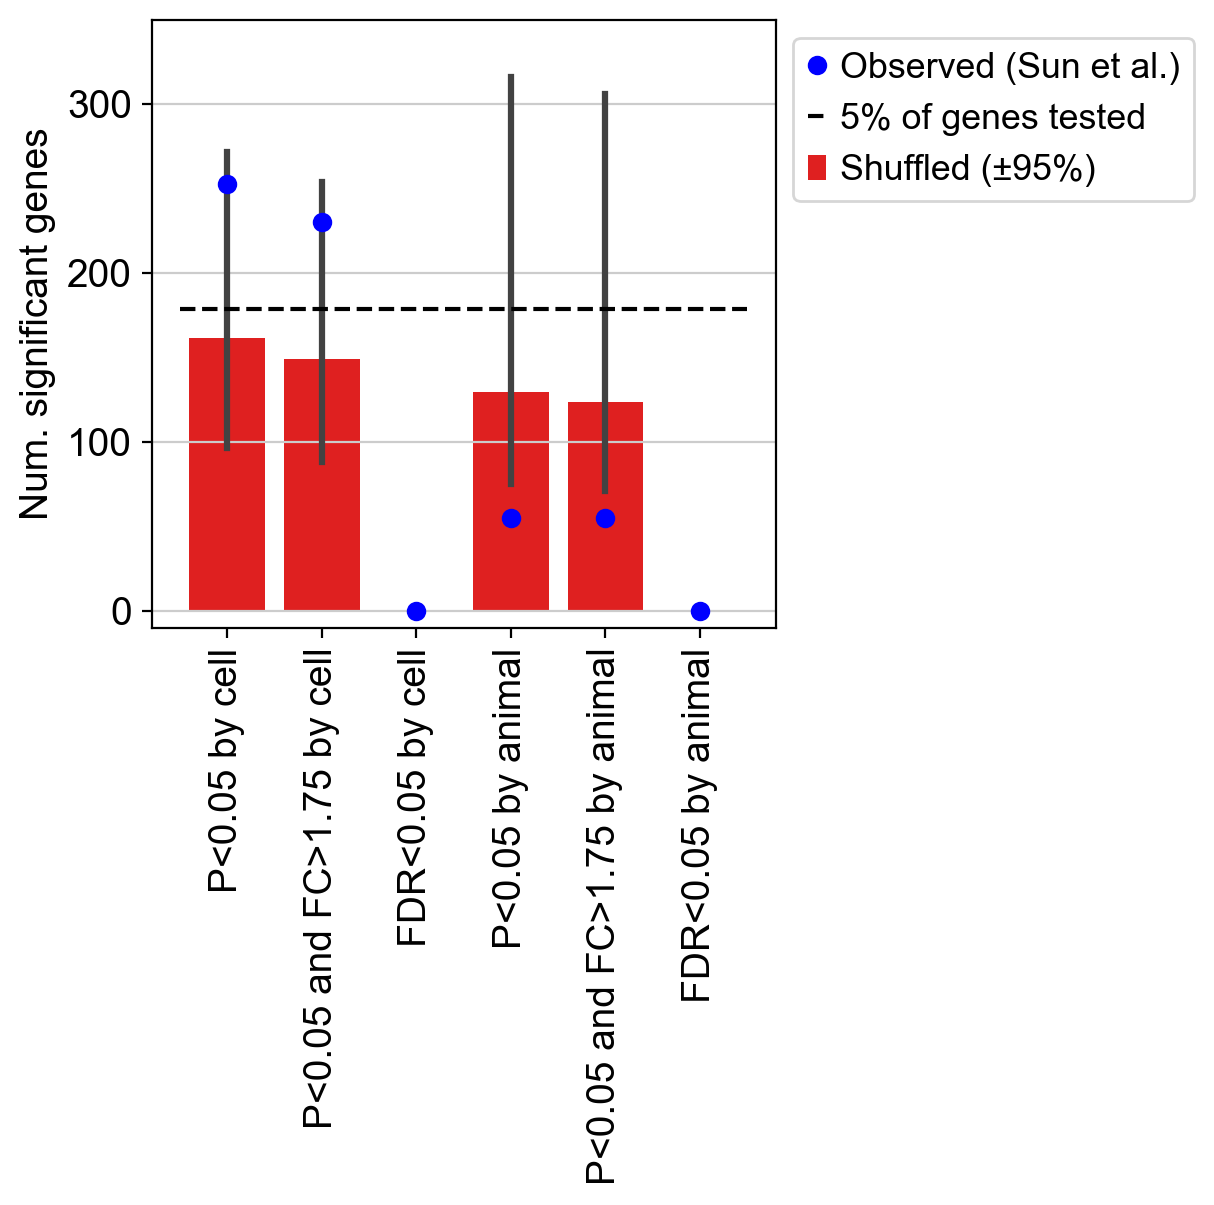

In [74]:
ax=sns.barplot(ngenes_df,orient='v',color='r',
              errorbar=('pi',95),
               label='Shuffled (±95%)')
ax.set_ylabel('Num. significant genes')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.plot([0,1,2,3,4,5],[ngenes_noshuff[k] for k in ngenes_df.columns],
        'bo', label='Observed (Sun et al.)')
ax.hlines(ngenes_tested*0.05,-.5,5.5,'k',linestyle='--',
          label='5% of genes tested')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim([-10,350])

In [75]:
ax.figure.savefig('Plots/SunQuake_Shuffle_Barplot.pdf')

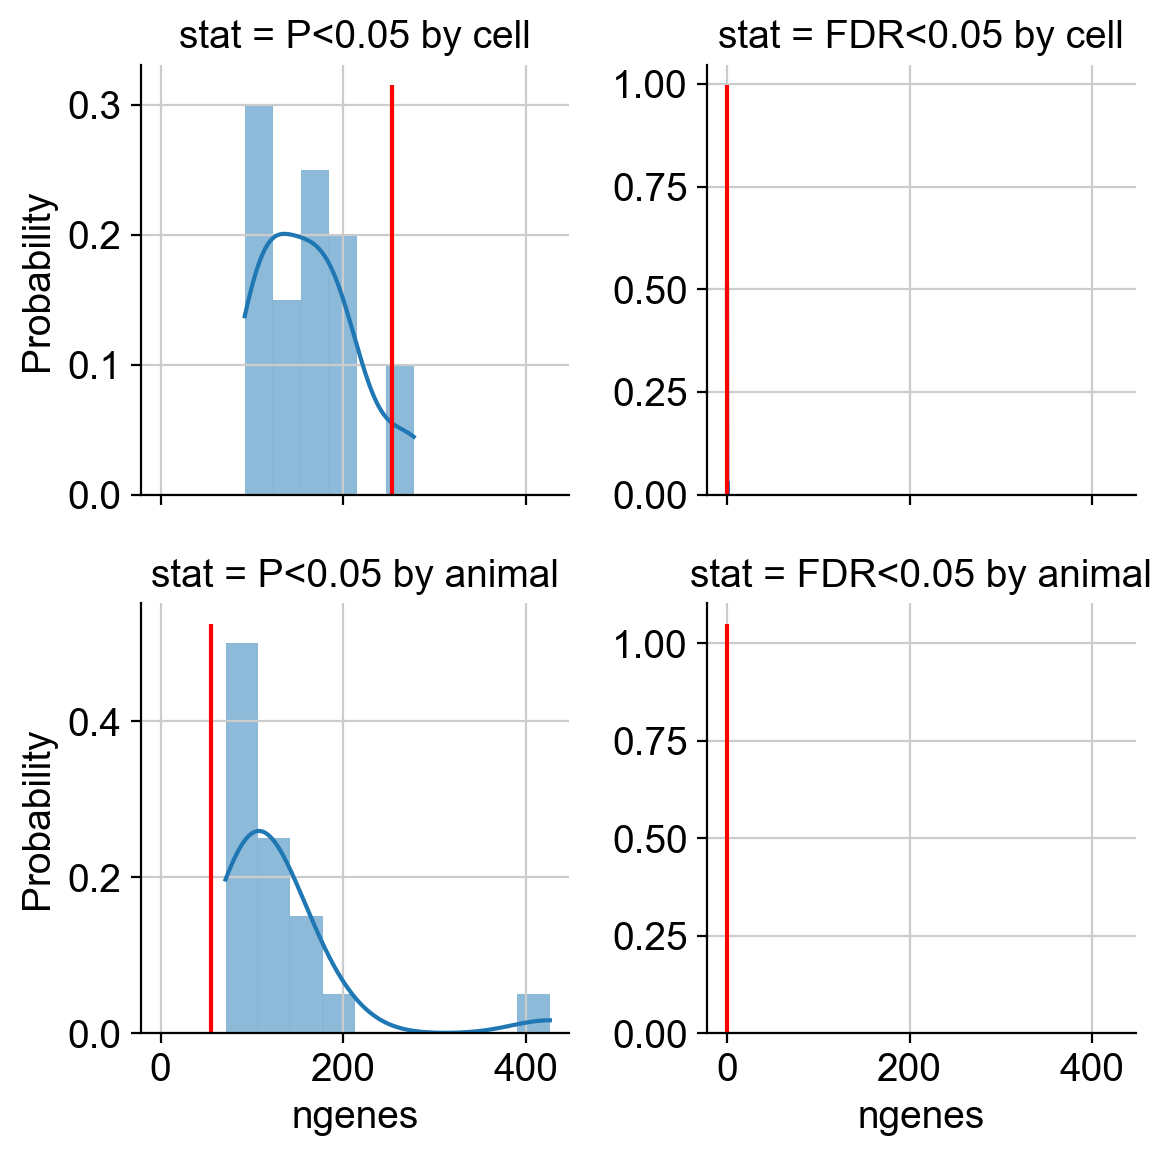

In [72]:
ngenes_dfu=ngenes_df.stack().reset_index()
ngenes_dfu.columns=['iter','stat','ngenes']
g=sns.displot(ngenes_dfu,kind='hist',
              col='stat',col_order=['P<0.05 by cell','FDR<0.05 by cell','P<0.05 by animal','FDR<0.05 by animal'],col_wrap=2,
              x='ngenes',
            height=3,
            # bins=np.arange(0,600,30),
              common_bins=False,
              kde=True,
            common_norm=False,
            stat='probability',
            facet_kws=dict(sharex=True,sharey=False),
           )
for stat in g.axes_dict:
    ax=g.axes_dict[stat]
    ax.vlines(ngenes_noshuff[stat],*ax.get_ylim(),'r')